# Exemplary analysis of the PBMC3K single-cell RNA dataset

Dependencies

- scanpy==1.7.2
- anndata==0.7.6
- umap==0.5.1
- nmpy==1.19.4
- scipy==1.5.3
- pandas==1.1.4
- scikit-learn==0.23.2
- statsmodels==0.12.1
- python-igraph==0.9.1
- louvain==0.7.0


In [1]:
from typing import Optional
import csv
import scanpy as sc
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import math

rawdata_dir = os.path.join(os.getcwd(), "rawdata")
figure_dir = "/home/jovyan/work/figures"

# Global settings
sc.settings.verbosity = 0
sc.logging.print_header()
sc.settings.set_figure_params(dpi=300, facecolor='white')

scanpy==1.7.2 anndata==0.7.6 umap==0.5.1 numpy==1.20.2 scipy==1.6.2 pandas==1.2.3 scikit-learn==0.24.1 statsmodels==0.12.2 python-igraph==0.9.1 louvain==0.7.0


In [2]:
adata = sc.read_10x_mtx(rawdata_dir, var_names="gene_symbols", cache=False)
adata.var_names_make_unique()

In [3]:
sc.pp.filter_cells(adata, min_genes=200)
sc.pp.filter_genes(adata, min_cells=3)

In [4]:
adata.var['mt'] = adata.var_names.str.startswith('MT-')
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=False, inplace=True)

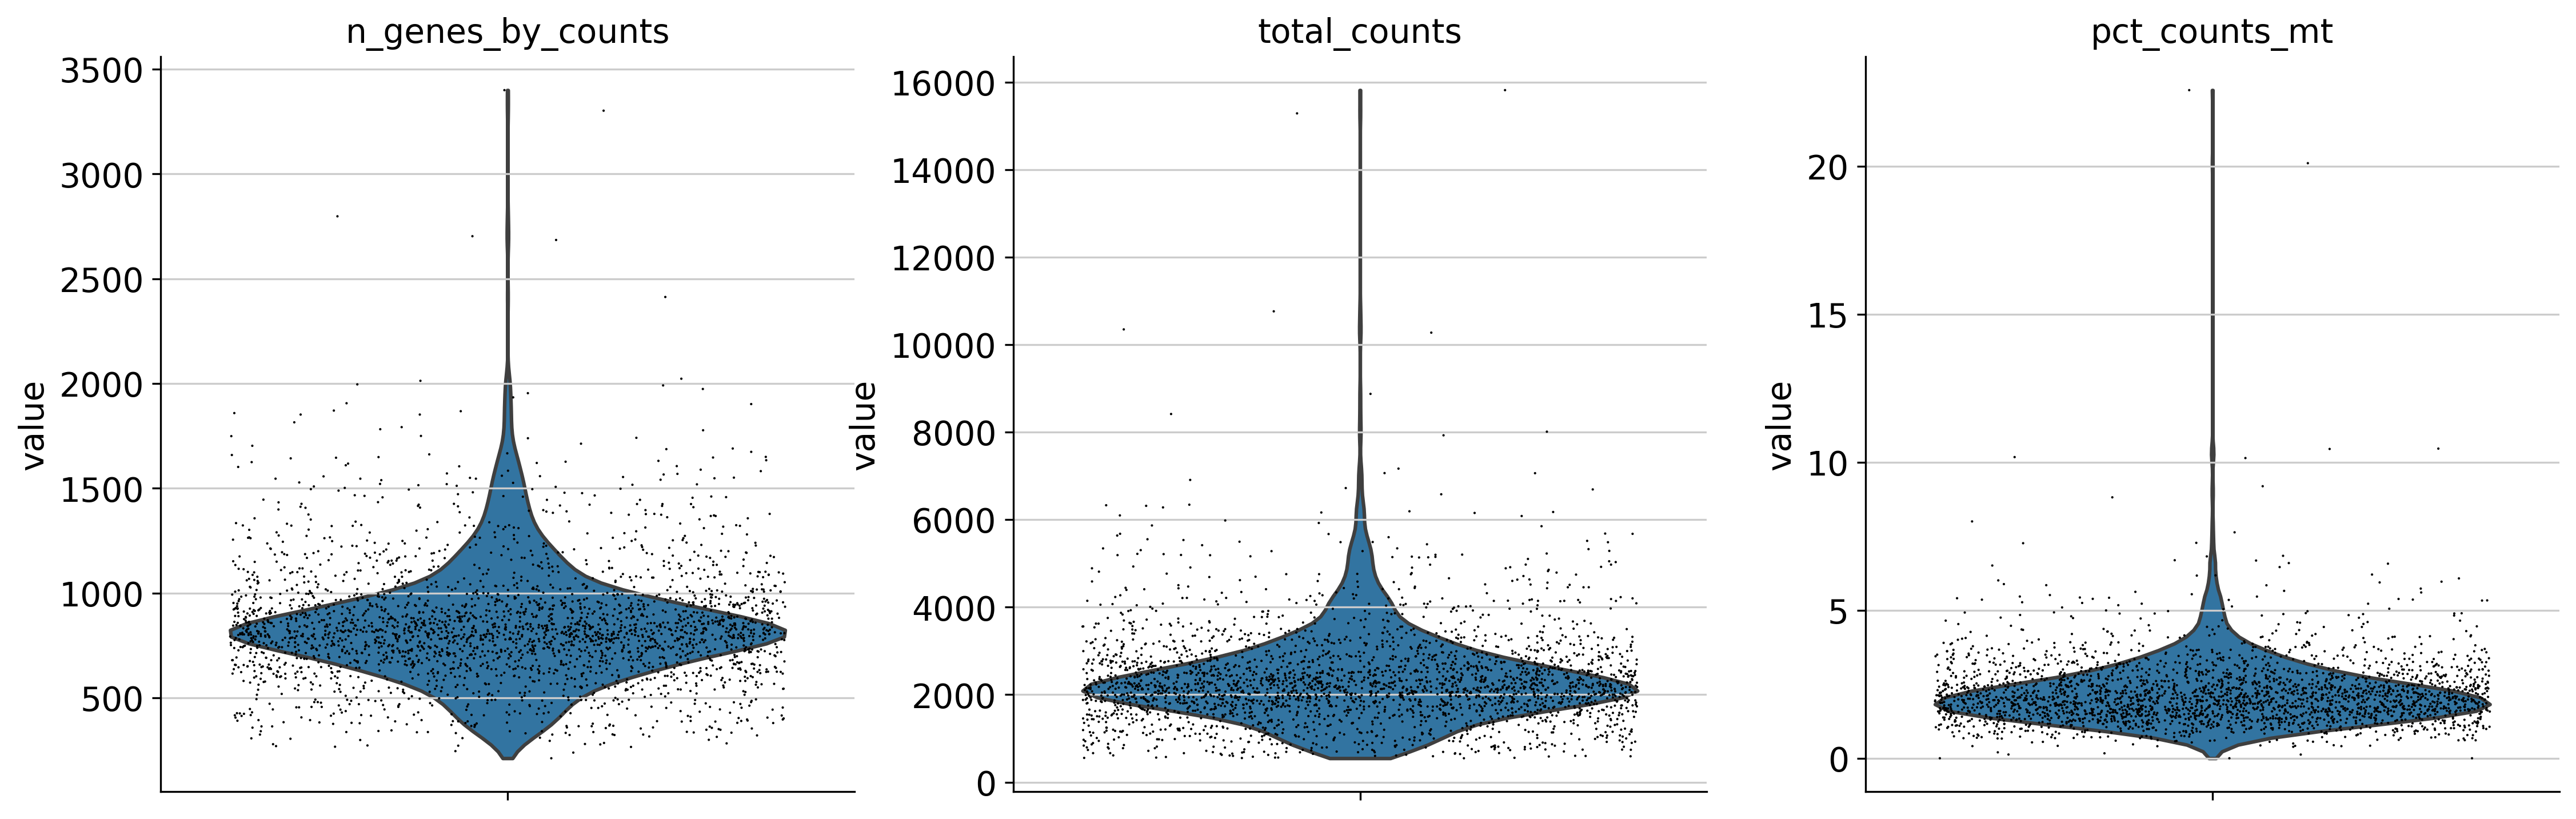

In [5]:
sc.pl.violin(adata, ['n_genes_by_counts', 'total_counts', 'pct_counts_mt'], jitter=0.4, multi_panel=True)

In [6]:
adata = adata[adata.obs.n_genes_by_counts < 2500, :]
adata = adata[adata.obs.pct_counts_mt < 5, :]

In [7]:
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

/opt/conda/lib/python3.8/site-packages/scanpy/preprocessing/_normalization.py:138: UserWarning: Revieved a view of an AnnData. Making a copy.
  view_to_actual(adata)


In [8]:
sc.pp.highly_variable_genes(adata, min_mean=0.0125, max_mean=3, min_disp=0.5)
adata.raw = adata
adata = adata[:, adata.var.highly_variable]

In [9]:
sc.pp.regress_out(adata, ['total_counts', 'pct_counts_mt'])
sc.pp.scale(adata, max_value=10)

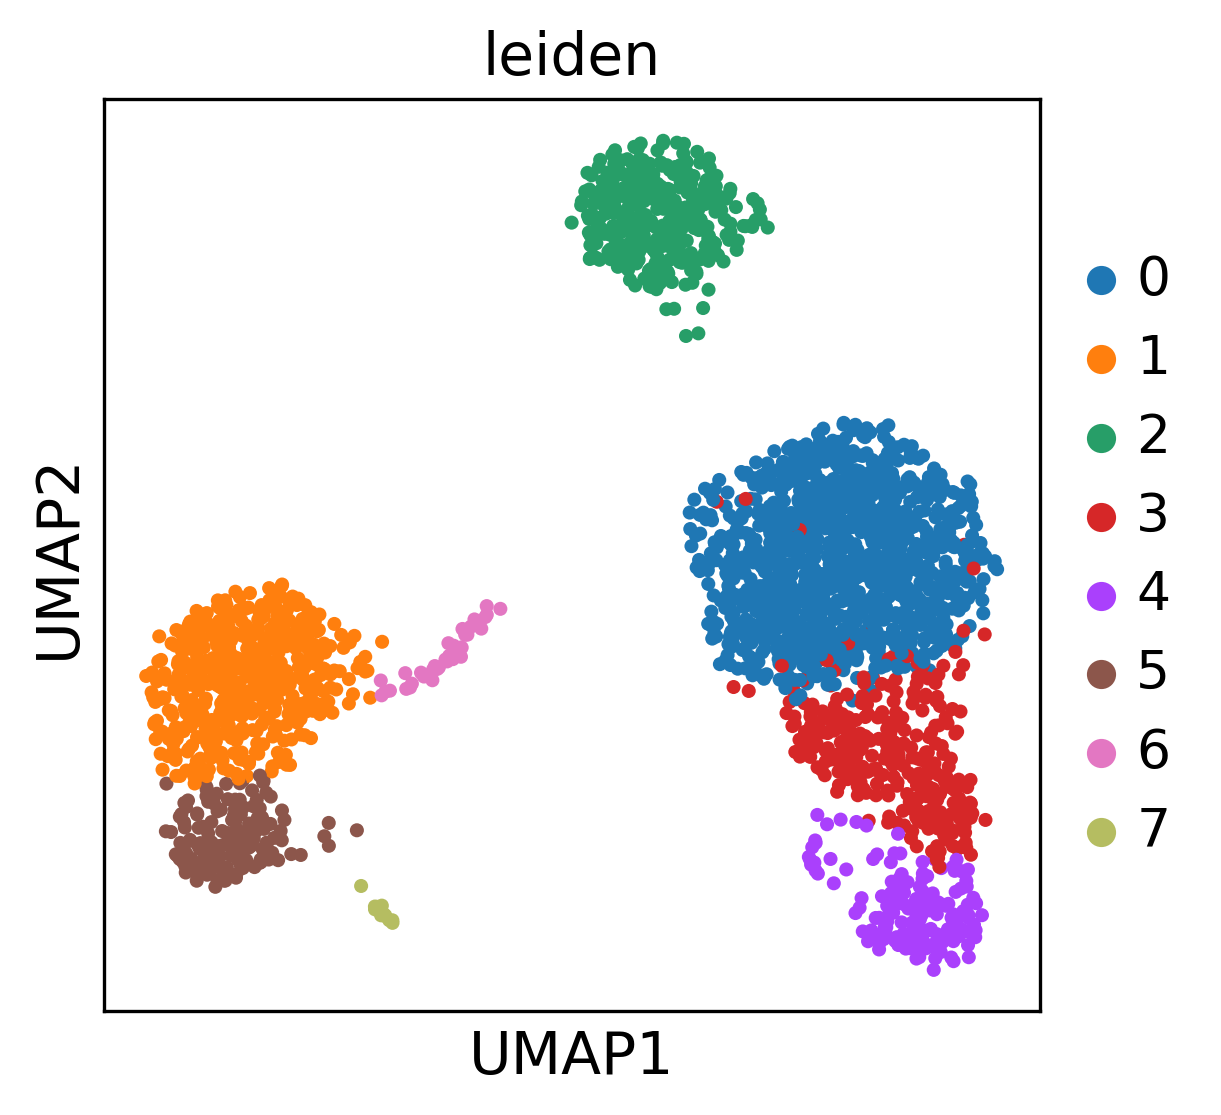

In [10]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pp.neighbors(adata, n_neighbors=10, n_pcs=40)
sc.tl.umap(adata)
sc.tl.leiden(adata)
sc.pl.umap(adata, color=['leiden'])

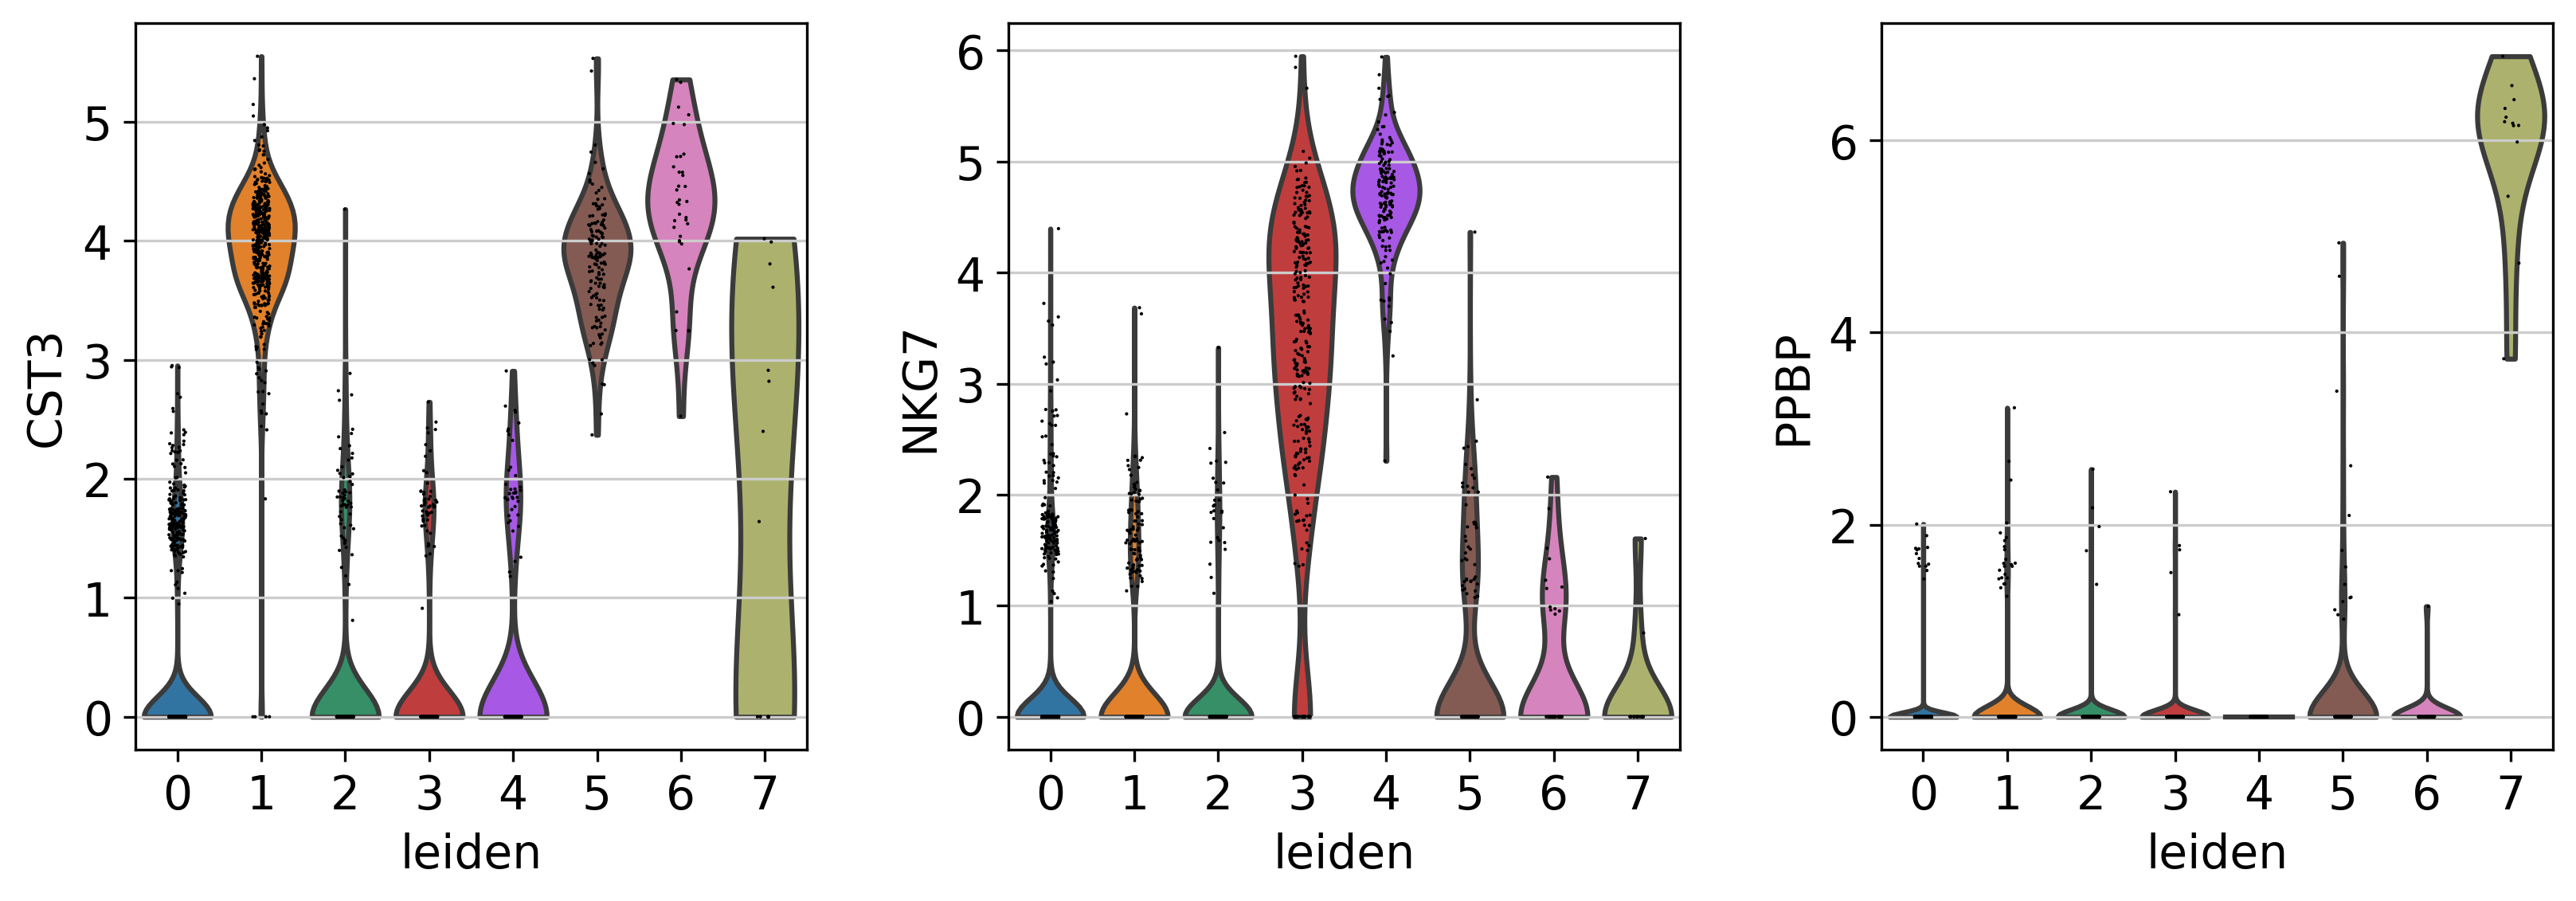

In [11]:
sc.pl.violin(adata, ['CST3', 'NKG7', 'PPBP'], groupby='leiden')

### Rename leiden clusters

In [12]:
new_cluster_names = [
    'CD4 T',
    'CD14 Monocytes',
    'B',
    'CD8 T',
    'NK',
    'FCGR3A Monocytes',
    'Dendritic',
    'Megakaryocytes'
]
adata.rename_categories('leiden', new_cluster_names)

### Generate final figure versions for paper

* marker genes violin plot
* UMAP plot with cluster annotation

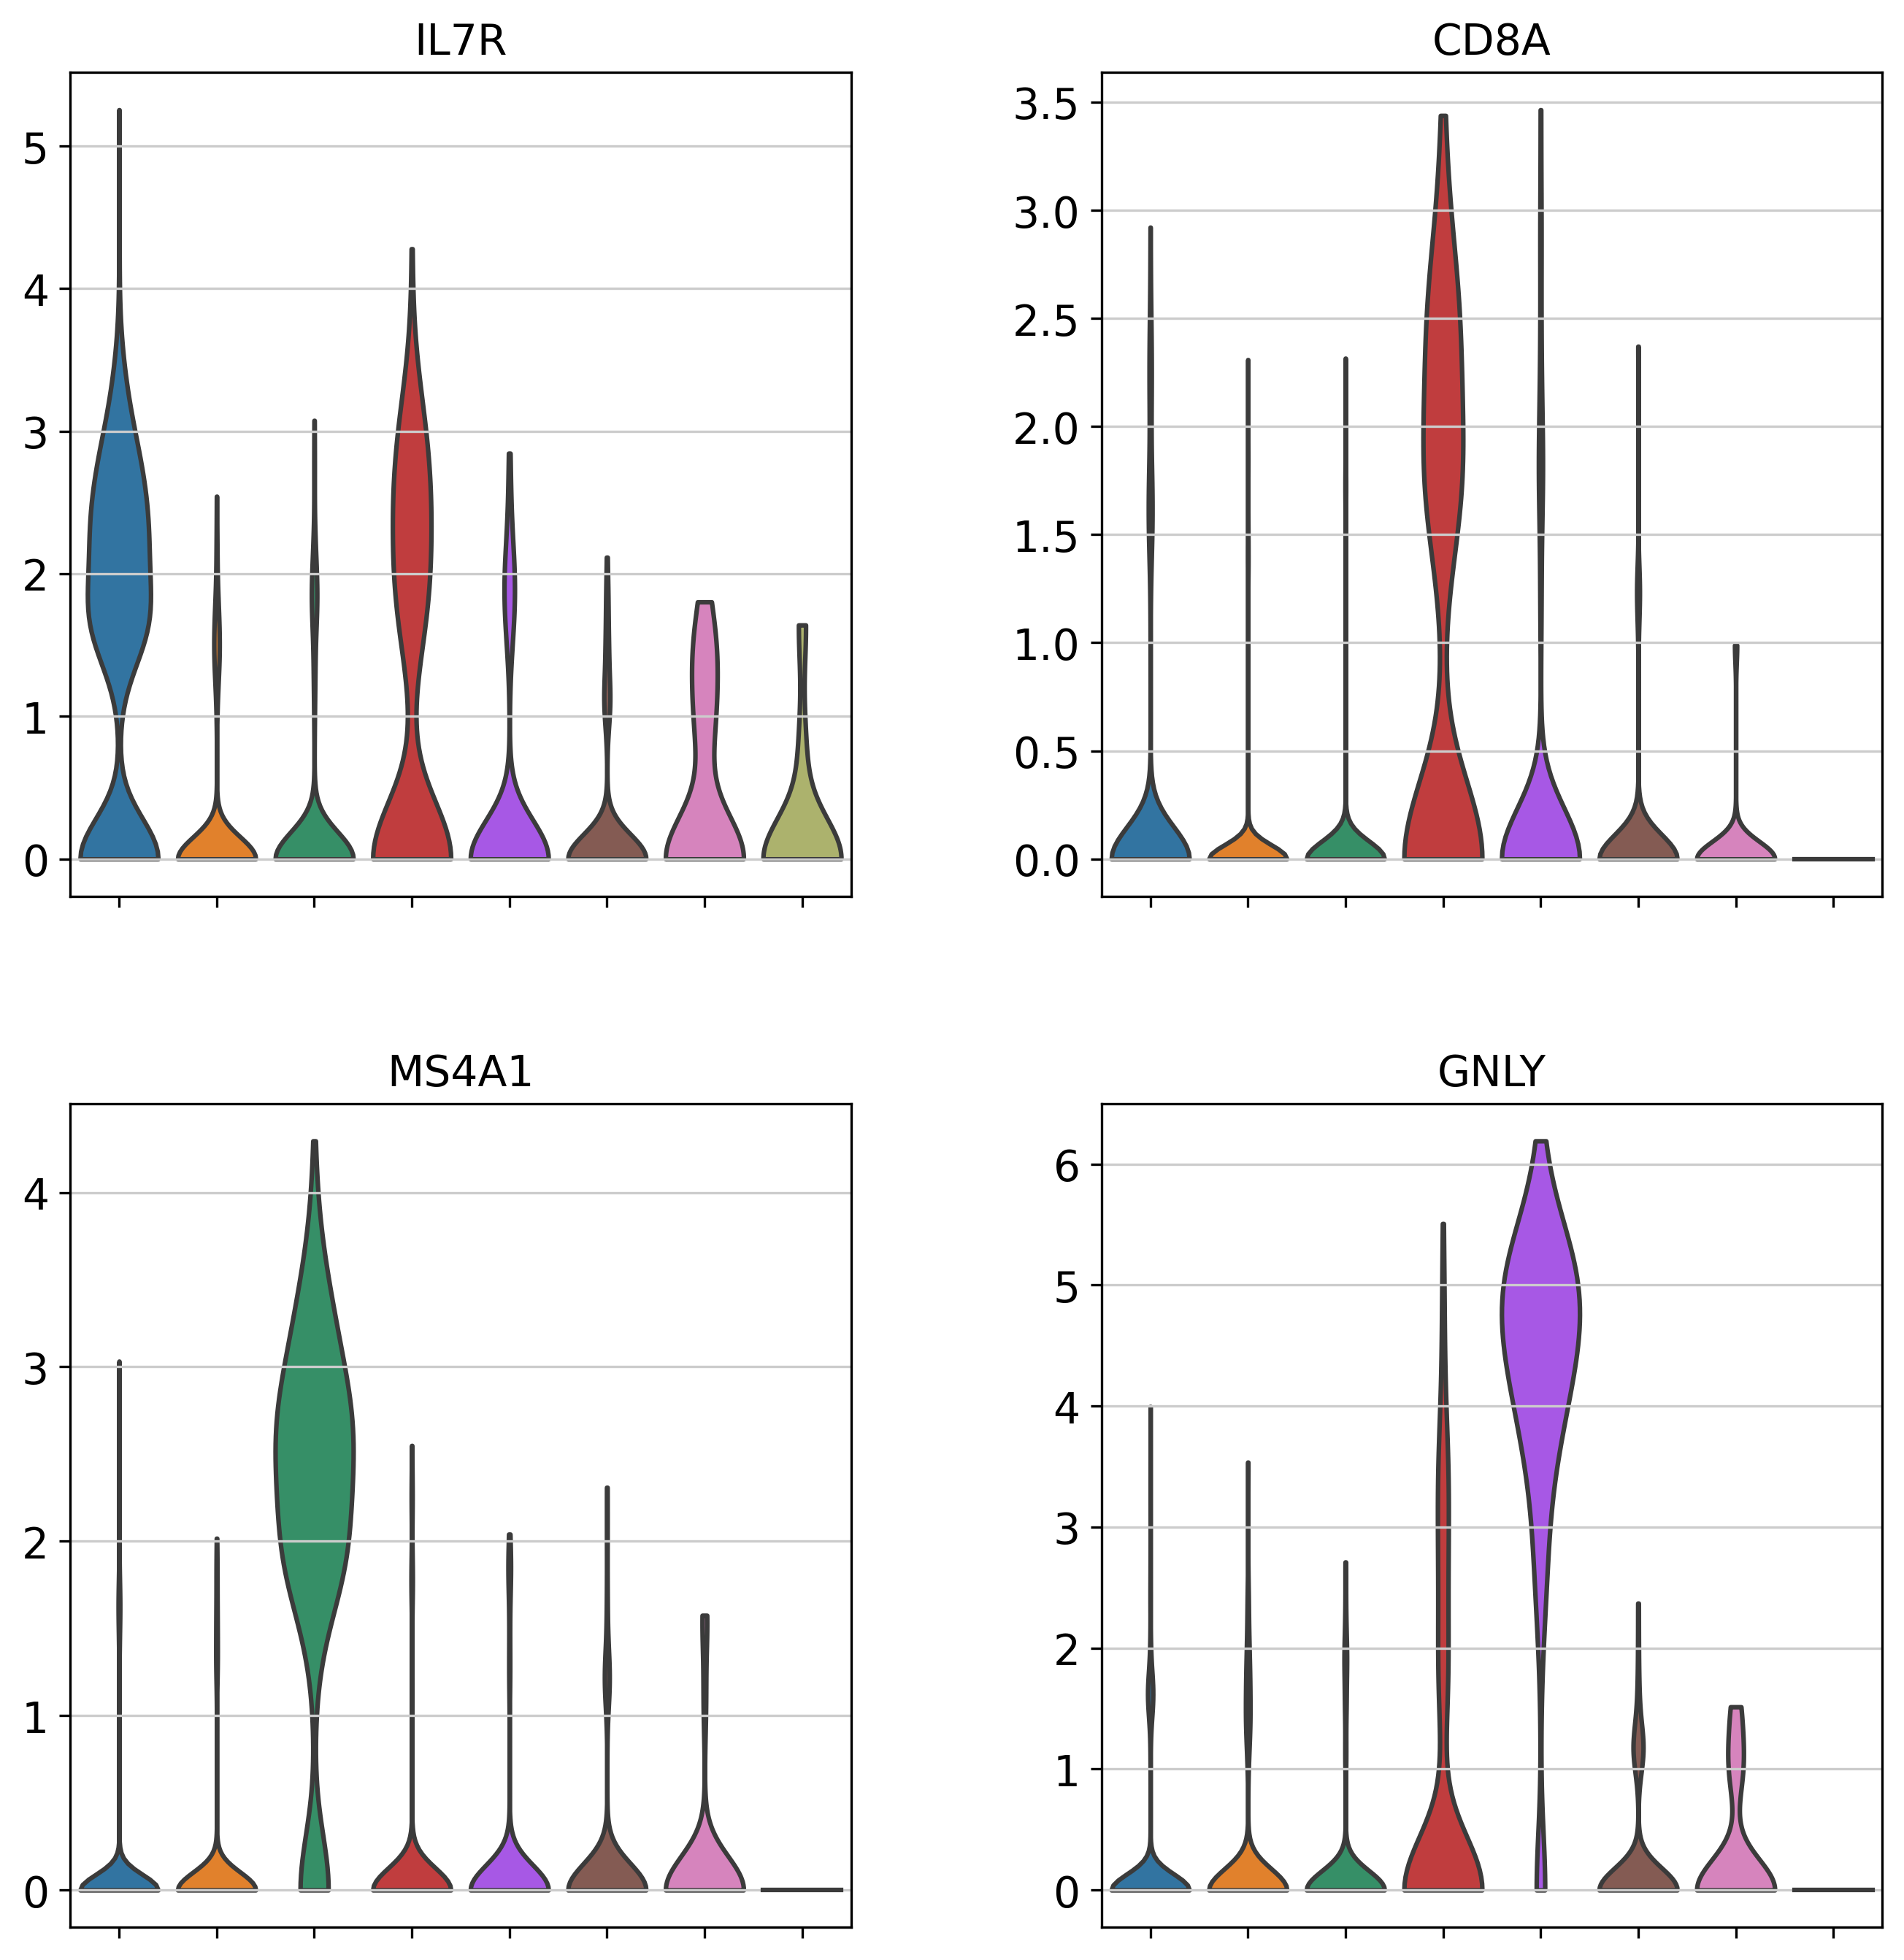

In [13]:
fig, ax = plt.subplots(2, 2, figsize=(10,10))
plt.tight_layout(pad=3.0)
for index, gene in enumerate(["IL7R", "MS4A1", "CD8A", "GNLY"]):
    x_pos = index % 2
    y_pos = math.floor(index / 2)

    sc.pl.violin(adata, gene, groupby='leiden', jitter=False, size=0, show=False, ax=ax[x_pos, y_pos])
    ax[x_pos, y_pos].set_title(gene)
    ax[x_pos, y_pos].set_xticklabels([])
    ax[x_pos, y_pos].set_ylabel("")
    ax[x_pos, y_pos].set_xlabel("")

plt.savefig(os.path.join(figure_dir, "figure3.png"))


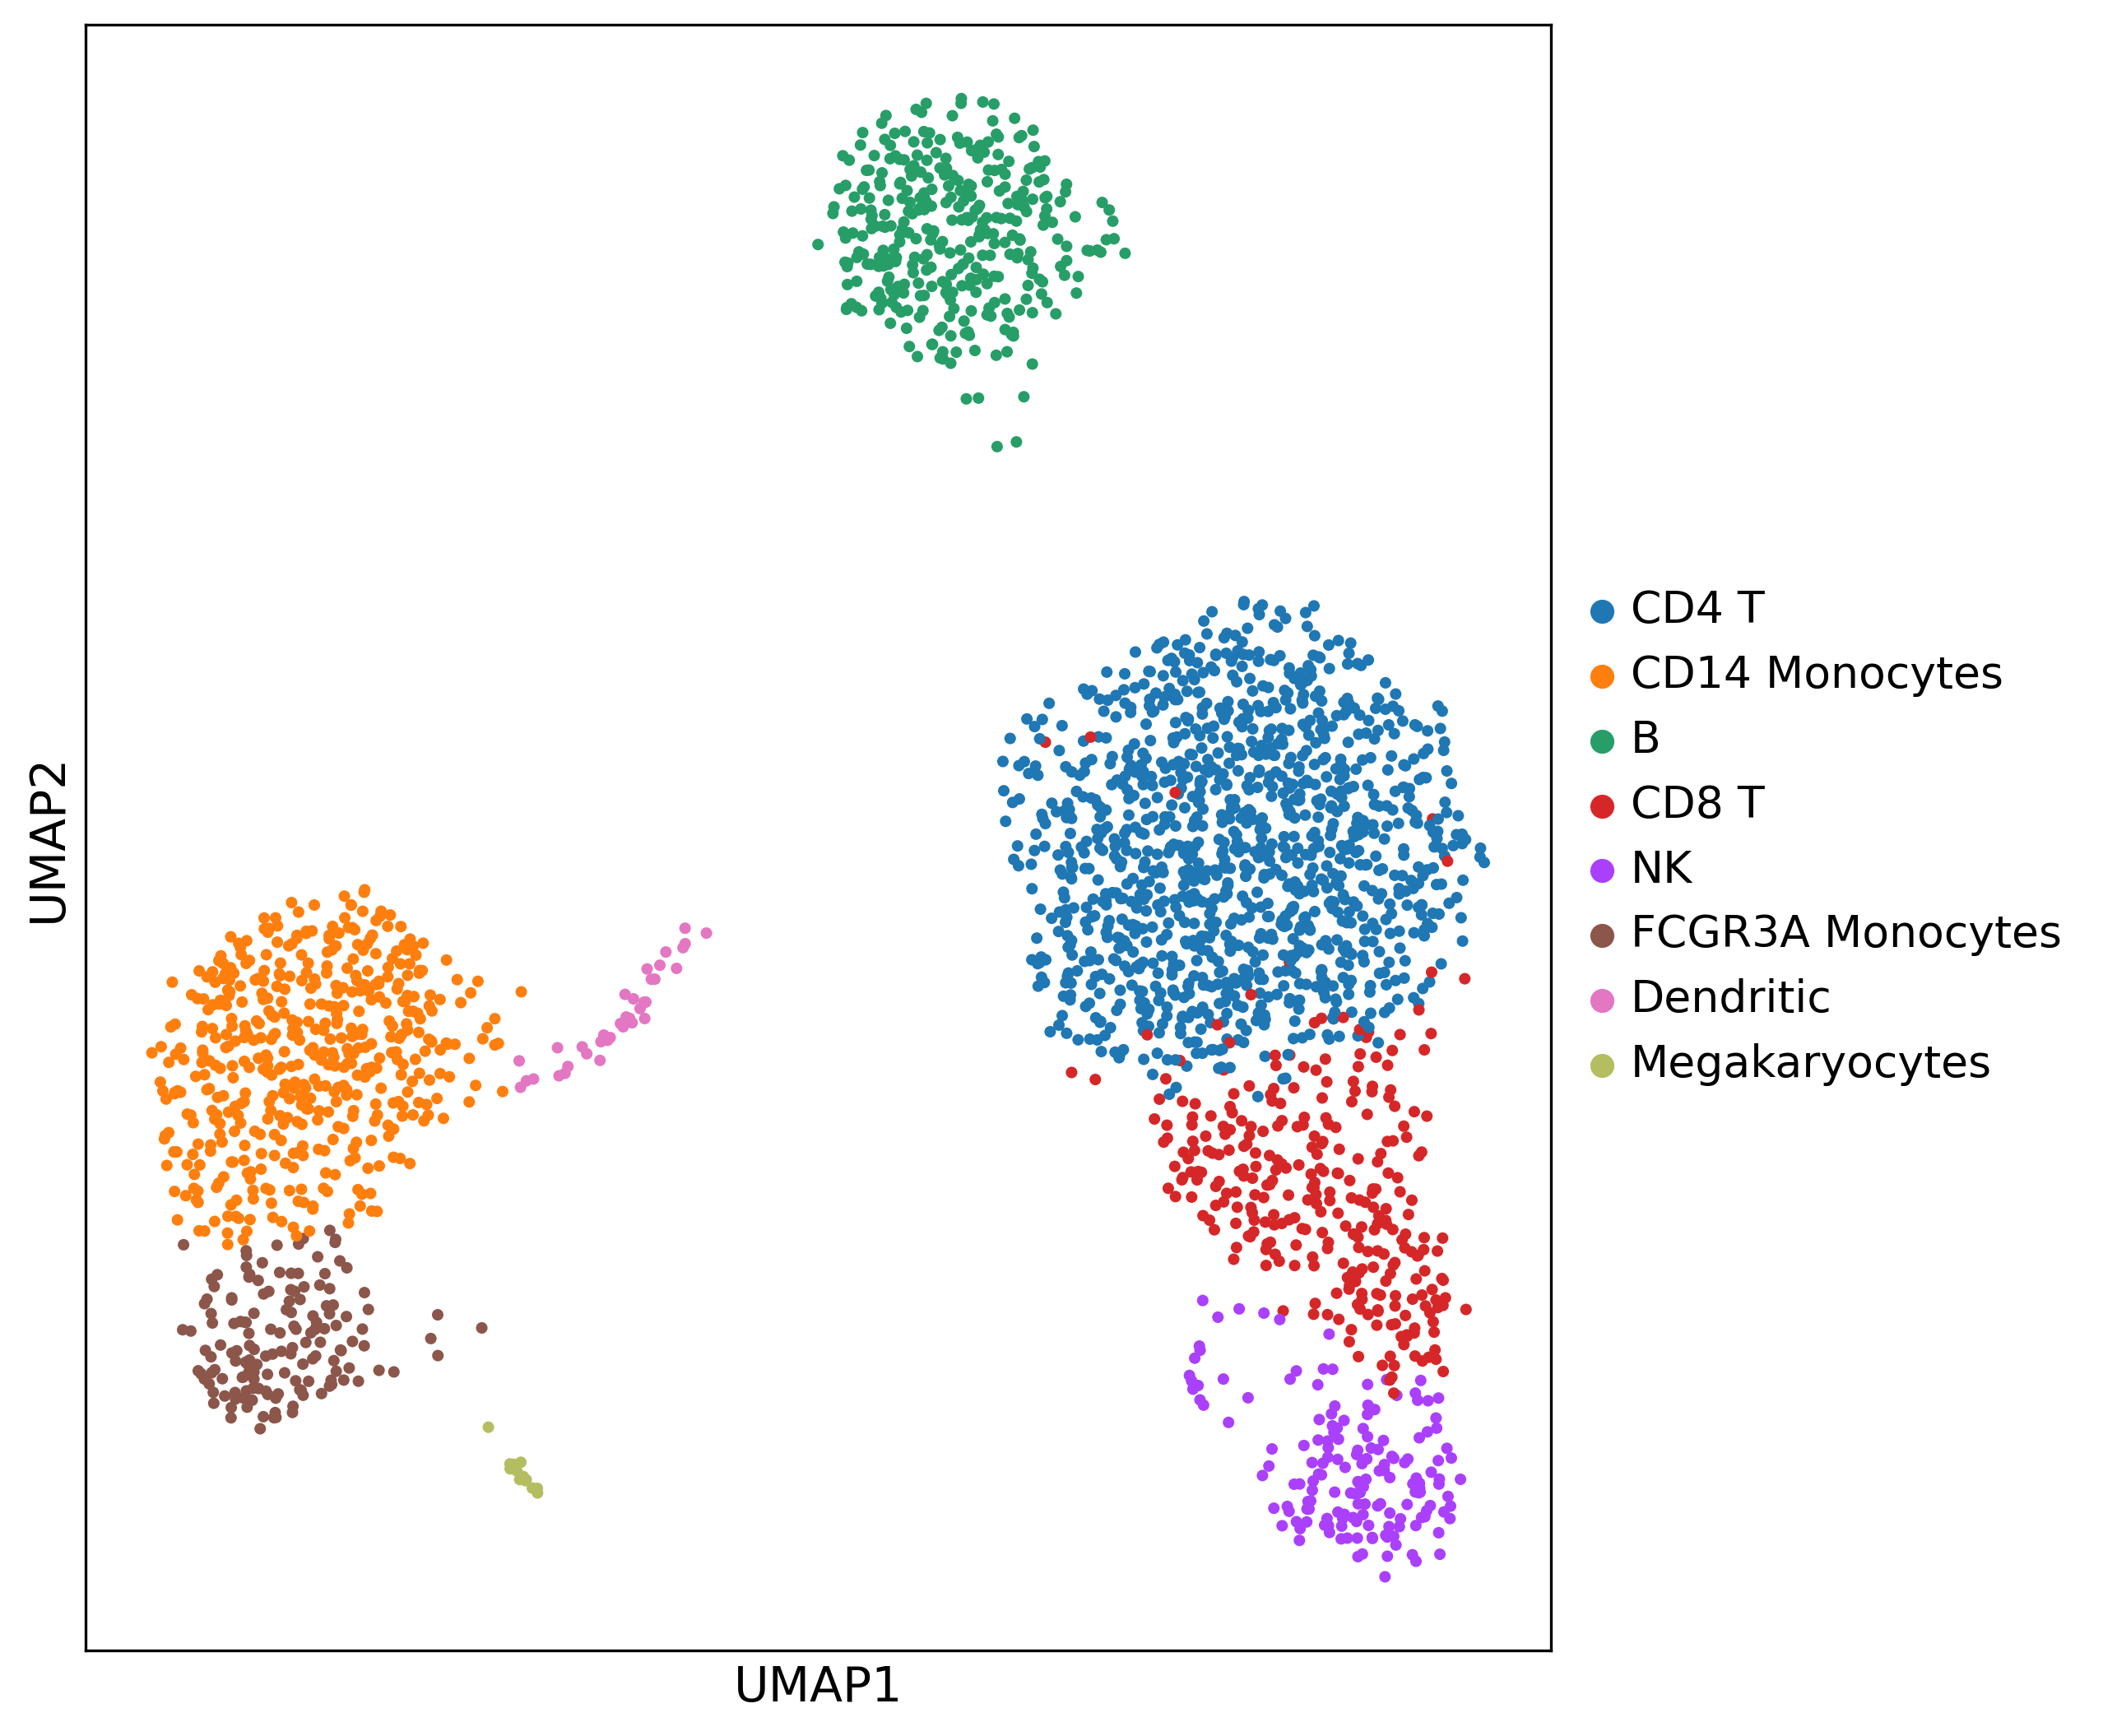

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ax.set_aspect('equal', adjustable='box')
sc.pl.umap(adata, color='leiden', legend_loc='right margin', title='', frameon=True, ax=ax, show=False)
plt.tight_layout(pad=3.0)

plt.savefig(os.path.join(figure_dir, "figure2.png"))

### Differential analysis results to pandas dataframe

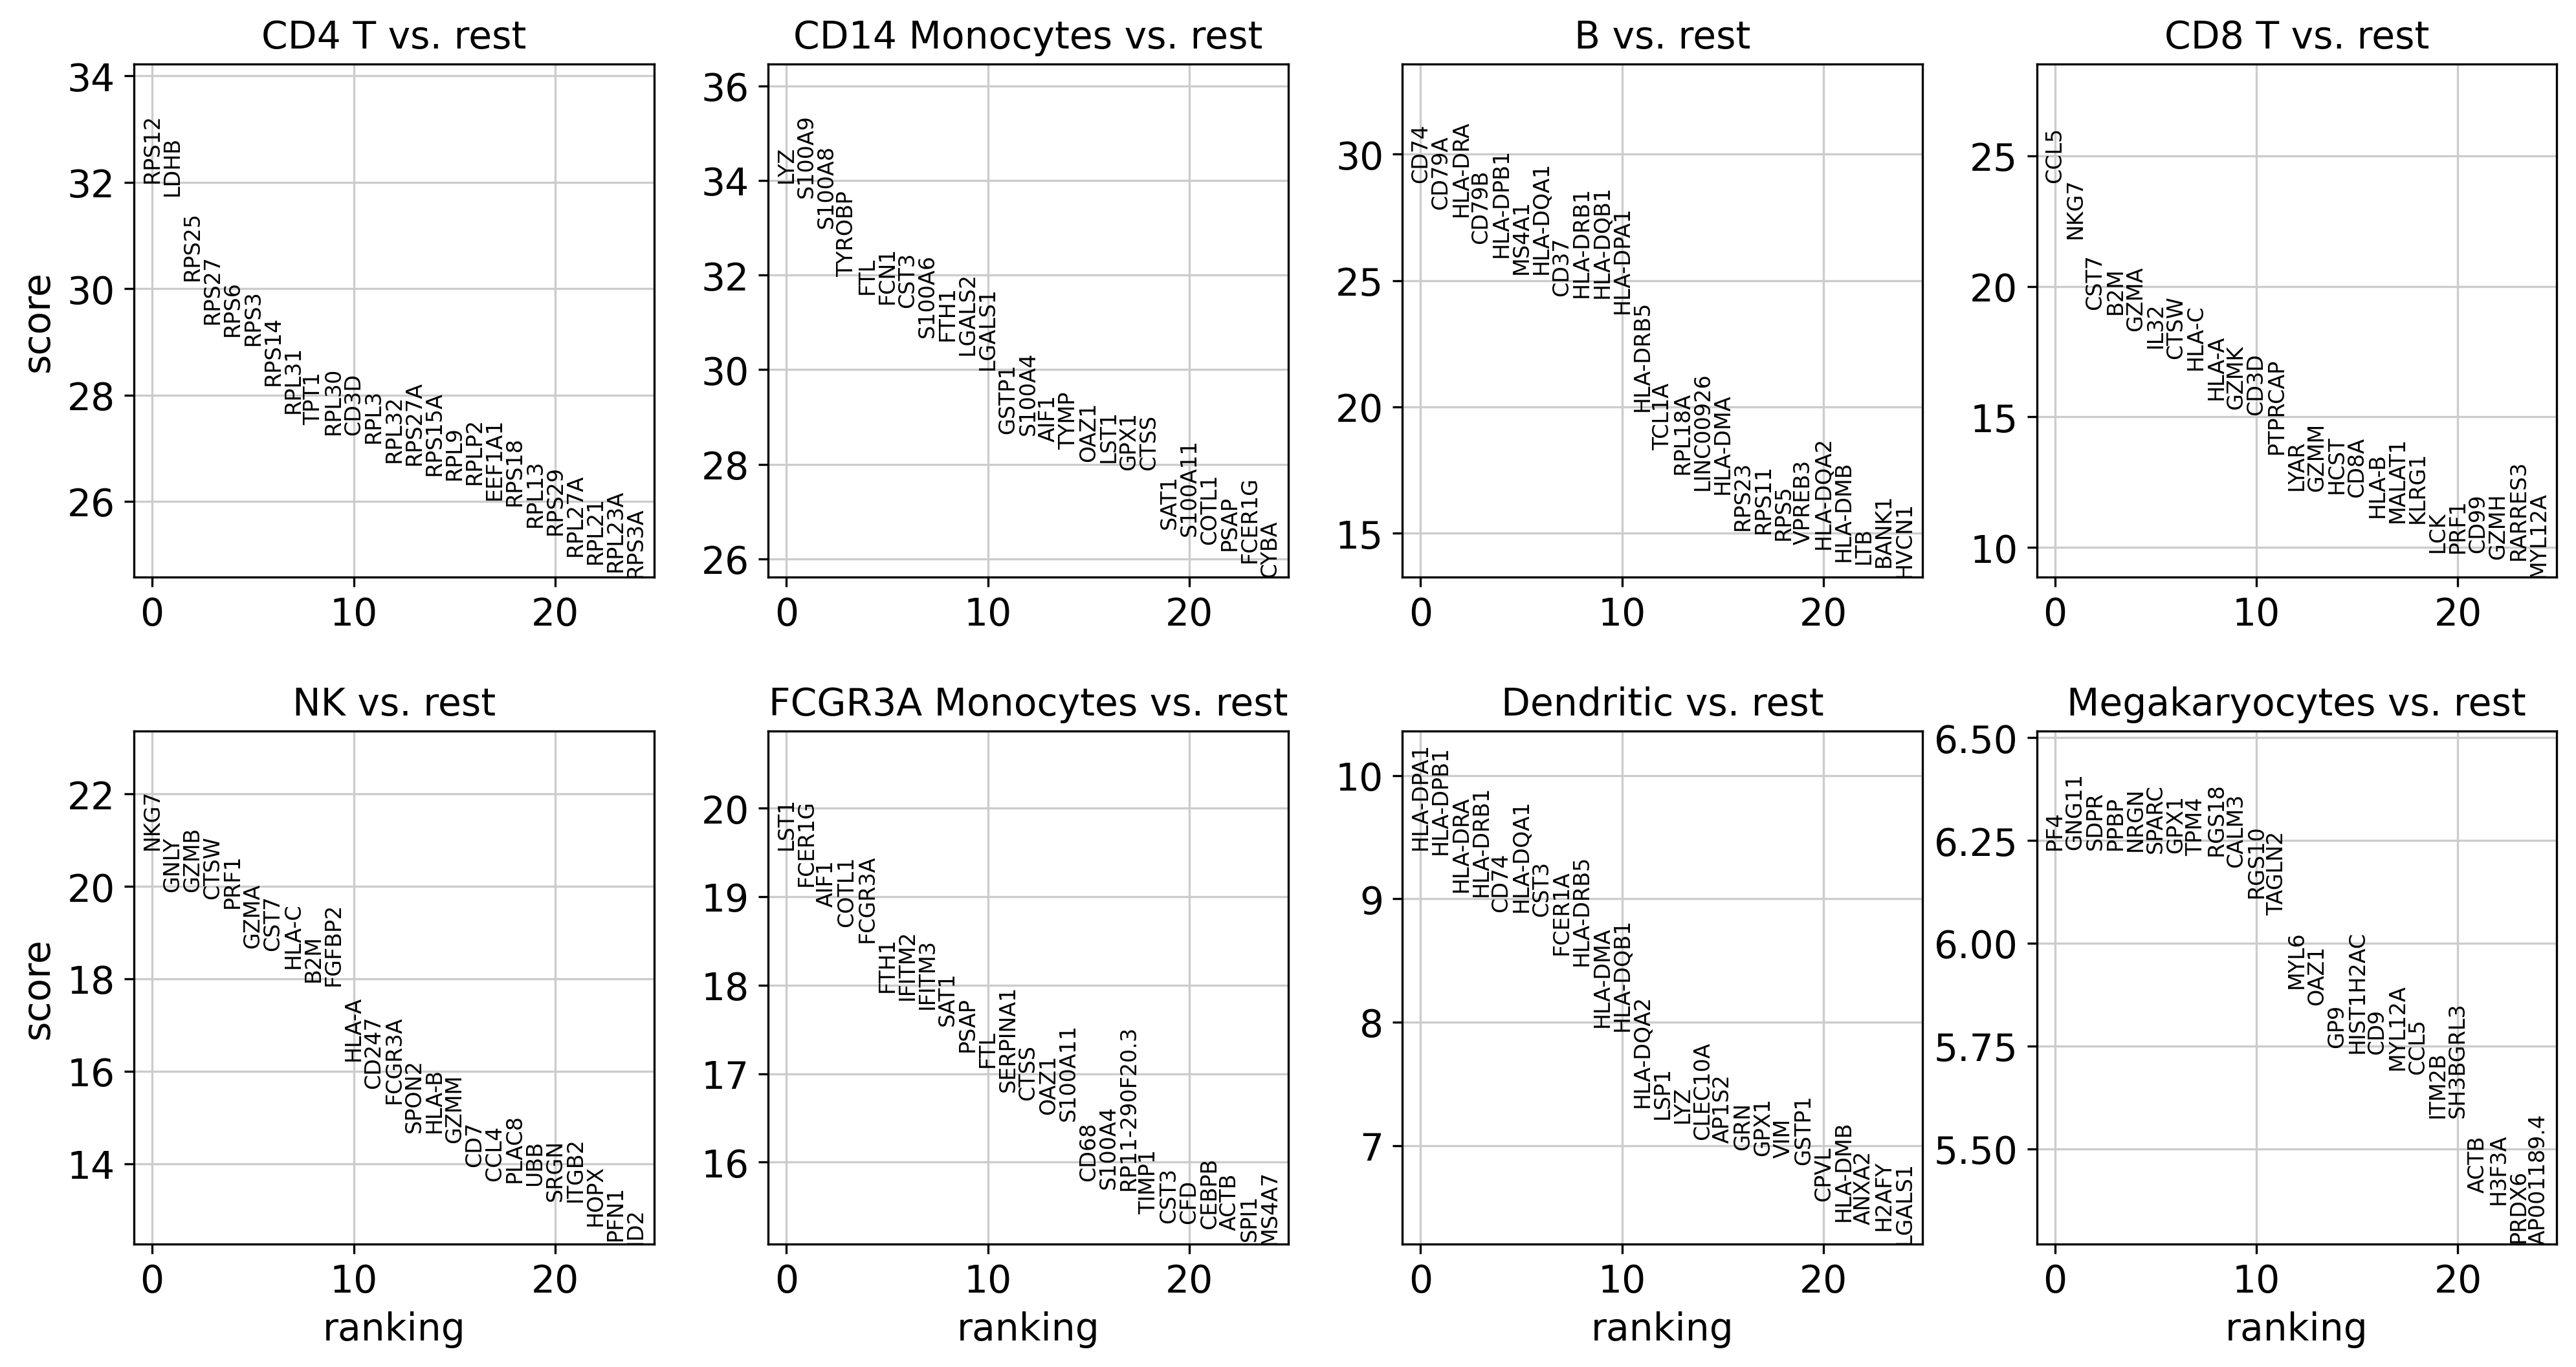

CD4 T CD14 Monocytes         B CD8 T    NK FCGR3A Monocytes Dendritic  \
0  RPS12            LYZ      CD74  CCL5  NKG7             LST1  HLA-DPA1   
1   LDHB         S100A9     CD79A  NKG7  GNLY           FCER1G  HLA-DPB1   
2  RPS25         S100A8   HLA-DRA  CST7  GZMB             AIF1   HLA-DRA   
3  RPS27         TYROBP     CD79B   B2M  CTSW            COTL1  HLA-DRB1   
4   RPS6            FTL  HLA-DPB1  GZMA  PRF1           FCGR3A      CD74   

  Megakaryocytes  
0            PF4  
1          GNG11  
2           SDPR  
3           PPBP  
4           NRGN

In [15]:
sc.tl.rank_genes_groups(adata, 'leiden', method='wilcoxon', n_genes=100)
sc.pl.rank_genes_groups(adata, n_genes=25, sharey=False)
pd.DataFrame(adata.uns['rank_genes_groups']['names']).head(5)

In [16]:
def export_uns_data(adata_obj,
                    descriptor: Optional[str] = "rank_genes_groups",
                    filename: Optional[str] = None,
                    basedir: Optional[str] = None,
                    extract_cols=["names", "pvals", "pvals_adj", "logfoldchanges"],
                    overwrite=False):
    
    if not basedir:
        basedir = os.getcwd()
    
    # descriptor = "rank_genes_groups"
    print(f"Exporting differential expression data for '{descriptor}'\n" + \
         "\n".join([f"\t{key}: {value}" for key, value in adata_obj.uns[descriptor]["params"].items()]))

    n_clusters = len(adata_obj.uns[descriptor]["names"][0])
    n_clusters

    data = {"cluster": []}
    for col in extract_cols:
        data[col] = []

    results_df = pd.DataFrame(data)

    items_per_cluster = len(np.array([list(i) for i in np.array(adata_obj.uns[descriptor][extract_cols[0]])])[:,0])

    for cluster in range(0, n_clusters):

        data = {"cluster": []}
        for col in extract_cols:
            data[col] = []

        df = pd.DataFrame(data)

        df["cluster"] = pd.array([cluster] * items_per_cluster, dtype="Int32")

        for col in extract_cols:
            cluster_vars = np.array([list(i) for i in np.array(adata_obj.uns[descriptor][col])])[:,cluster]
            df[col] = cluster_vars

        results_df = results_df.append(df)
        
    if filename:
        # return results_df
        full_filename = os.path.join(basedir, filename)
        if os.path.isfile(full_filename) and not overwrite:
            raise FileExistsError(f"File {full_filename} already exists")

        results_df.to_csv(full_filename, index=False)
        
    return results_df

In [17]:
diffexp_df = export_uns_data(adata, filename="export_uns.csv", overwrite=True)
diffexp_df.head()

Exporting differential expression data for 'rank_genes_groups'
	groupby: leiden
	reference: rest
	method: wilcoxon
	use_raw: True
	layer: None
	corr_method: benjamini-hochberg


cluster  names          pvals      pvals_adj  logfoldchanges
0        0  RPS12  1.238286e-224  1.698185e-220        1.044792
1        0   LDHB  2.520407e-221  1.728243e-217        2.677442
2        0  RPS25  7.723960e-200  2.118528e-196        1.165159
3        0  RPS27  3.232559e-189  6.333044e-186        1.018170
4        0   RPS6  2.474817e-186  4.242454e-183        0.868466

### Perform KEGGTOOLS enrichment analysis

In [18]:
# KEGGTOOLS imports
import logging
logging.basicConfig(level=logging.DEBUG)
from keggtools.models import KEGGPathway
from keggtools.resolver import KEGGPathwayResolver
from keggtools.analysis import KEGGPathwayAnalysisResult, KEGGPathwayAnalysis
from keggtools.render import KEGGPathwayRenderer
from keggtools.storage import KEGGDataStorage
from keggtools.const import IMMUNE_SYSTEM_PATHWAYS

In [19]:
organism_id = "hsa"
# Analysed Cluster 4 (NK cells)
cluster = 4

In [20]:
diffexp_df = diffexp_df[diffexp_df["cluster"] == cluster]
diffexp_df.head()

cluster names         pvals     pvals_adj  logfoldchanges
0        4  NKG7  4.321025e-96  5.925854e-92        6.887014
1        4  GNLY  4.640732e-88  2.380879e-84        7.831739
2        4  GZMB  5.208282e-88  2.380879e-84        7.669129
3        4  CTSW  1.202514e-86  4.122818e-83        4.828786
4        4  PRF1  5.056639e-85  1.386935e-81        6.324315

In [21]:
analysis = KEGGPathwayAnalysis(org=organism_id, pathways=IMMUNE_SYSTEM_PATHWAYS)

### Convert to list of entez ids using mygene

In [22]:
# gene_list
import mygene
mg = mygene.MyGeneInfo()

In [23]:
gene_list = list(diffexp_df["names"])
query_result = mg.querymany(gene_list, scopes="symbol", species="human")

DEBUG:urllib3.connectionpool:Starting new HTTP connection (1): mygene.info:80


querying 1-100...

DEBUG:urllib3.connectionpool:http://mygene.info:80 "POST /v3/query/ HTTP/1.1" 200 None


done.
Finished.
3 input query terms found no hit:
	['RARRES3', 'SEPT7', 'GPR56']
Pass "returnall=True" to return complete lists of duplicate or missing query terms.


In [24]:
entrz_gene_list= []
for item in query_result:
    if "entrezgene" in item:
        # Append entrez id to list
        entrz_gene_list.append(int(item["entrezgene"]))
        
        # Add entrez id to dataframe
        diffexp_df.loc[diffexp_df["names"] == item["query"], "entrez"] = int(item["entrezgene"])
    else:
        print(f"Not found entrez id in result:", item)
        diffexp_df.loc[diffexp_df["names"] == item["query"], "entrez"] = 0

Not found entrez id in result: {'query': 'RARRES3', 'notfound': True}
Not found entrez id in result: {'query': 'SEPT7', 'notfound': True}
Not found entrez id in result: {'query': 'GPR56', 'notfound': True}


### Run enrichment analysis

In [25]:
analysis.run_analysis(gene_list=entrz_gene_list)
result = analysis.to_dataframe()

DEBUG:root:Load pathway path:hsa04640 from file
DEBUG:root:Get 67 unique genes from pathway
DEBUG:root:Load pathway path:hsa04610 from file
DEBUG:root:Get 62 unique genes from pathway
DEBUG:root:Load pathway path:hsa04611 from file
DEBUG:root:Get 64 unique genes from pathway
DEBUG:root:Load pathway path:hsa04620 from file
DEBUG:root:Get 67 unique genes from pathway
DEBUG:root:Load pathway path:hsa04621 from file
DEBUG:root:Get 113 unique genes from pathway
DEBUG:root:Load pathway path:hsa04622 from file
DEBUG:root:Get 50 unique genes from pathway
DEBUG:root:Load pathway path:hsa04623 from file
DEBUG:root:Get 29 unique genes from pathway
DEBUG:root:Load pathway path:hsa04625 from file
DEBUG:root:Get 67 unique genes from pathway
DEBUG:root:Load pathway path:hsa04650 from file
DEBUG:root:Get 70 unique genes from pathway
DEBUG:root:Load pathway path:hsa04612 from file
DEBUG:root:Get 25 unique genes from pathway
DEBUG:root:Load pathway path:hsa04660 from file
DEBUG:root:Get 63 unique genes 

### Plot results of enrichment analysis

DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f31dbcacac0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f31dbcacac0> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh


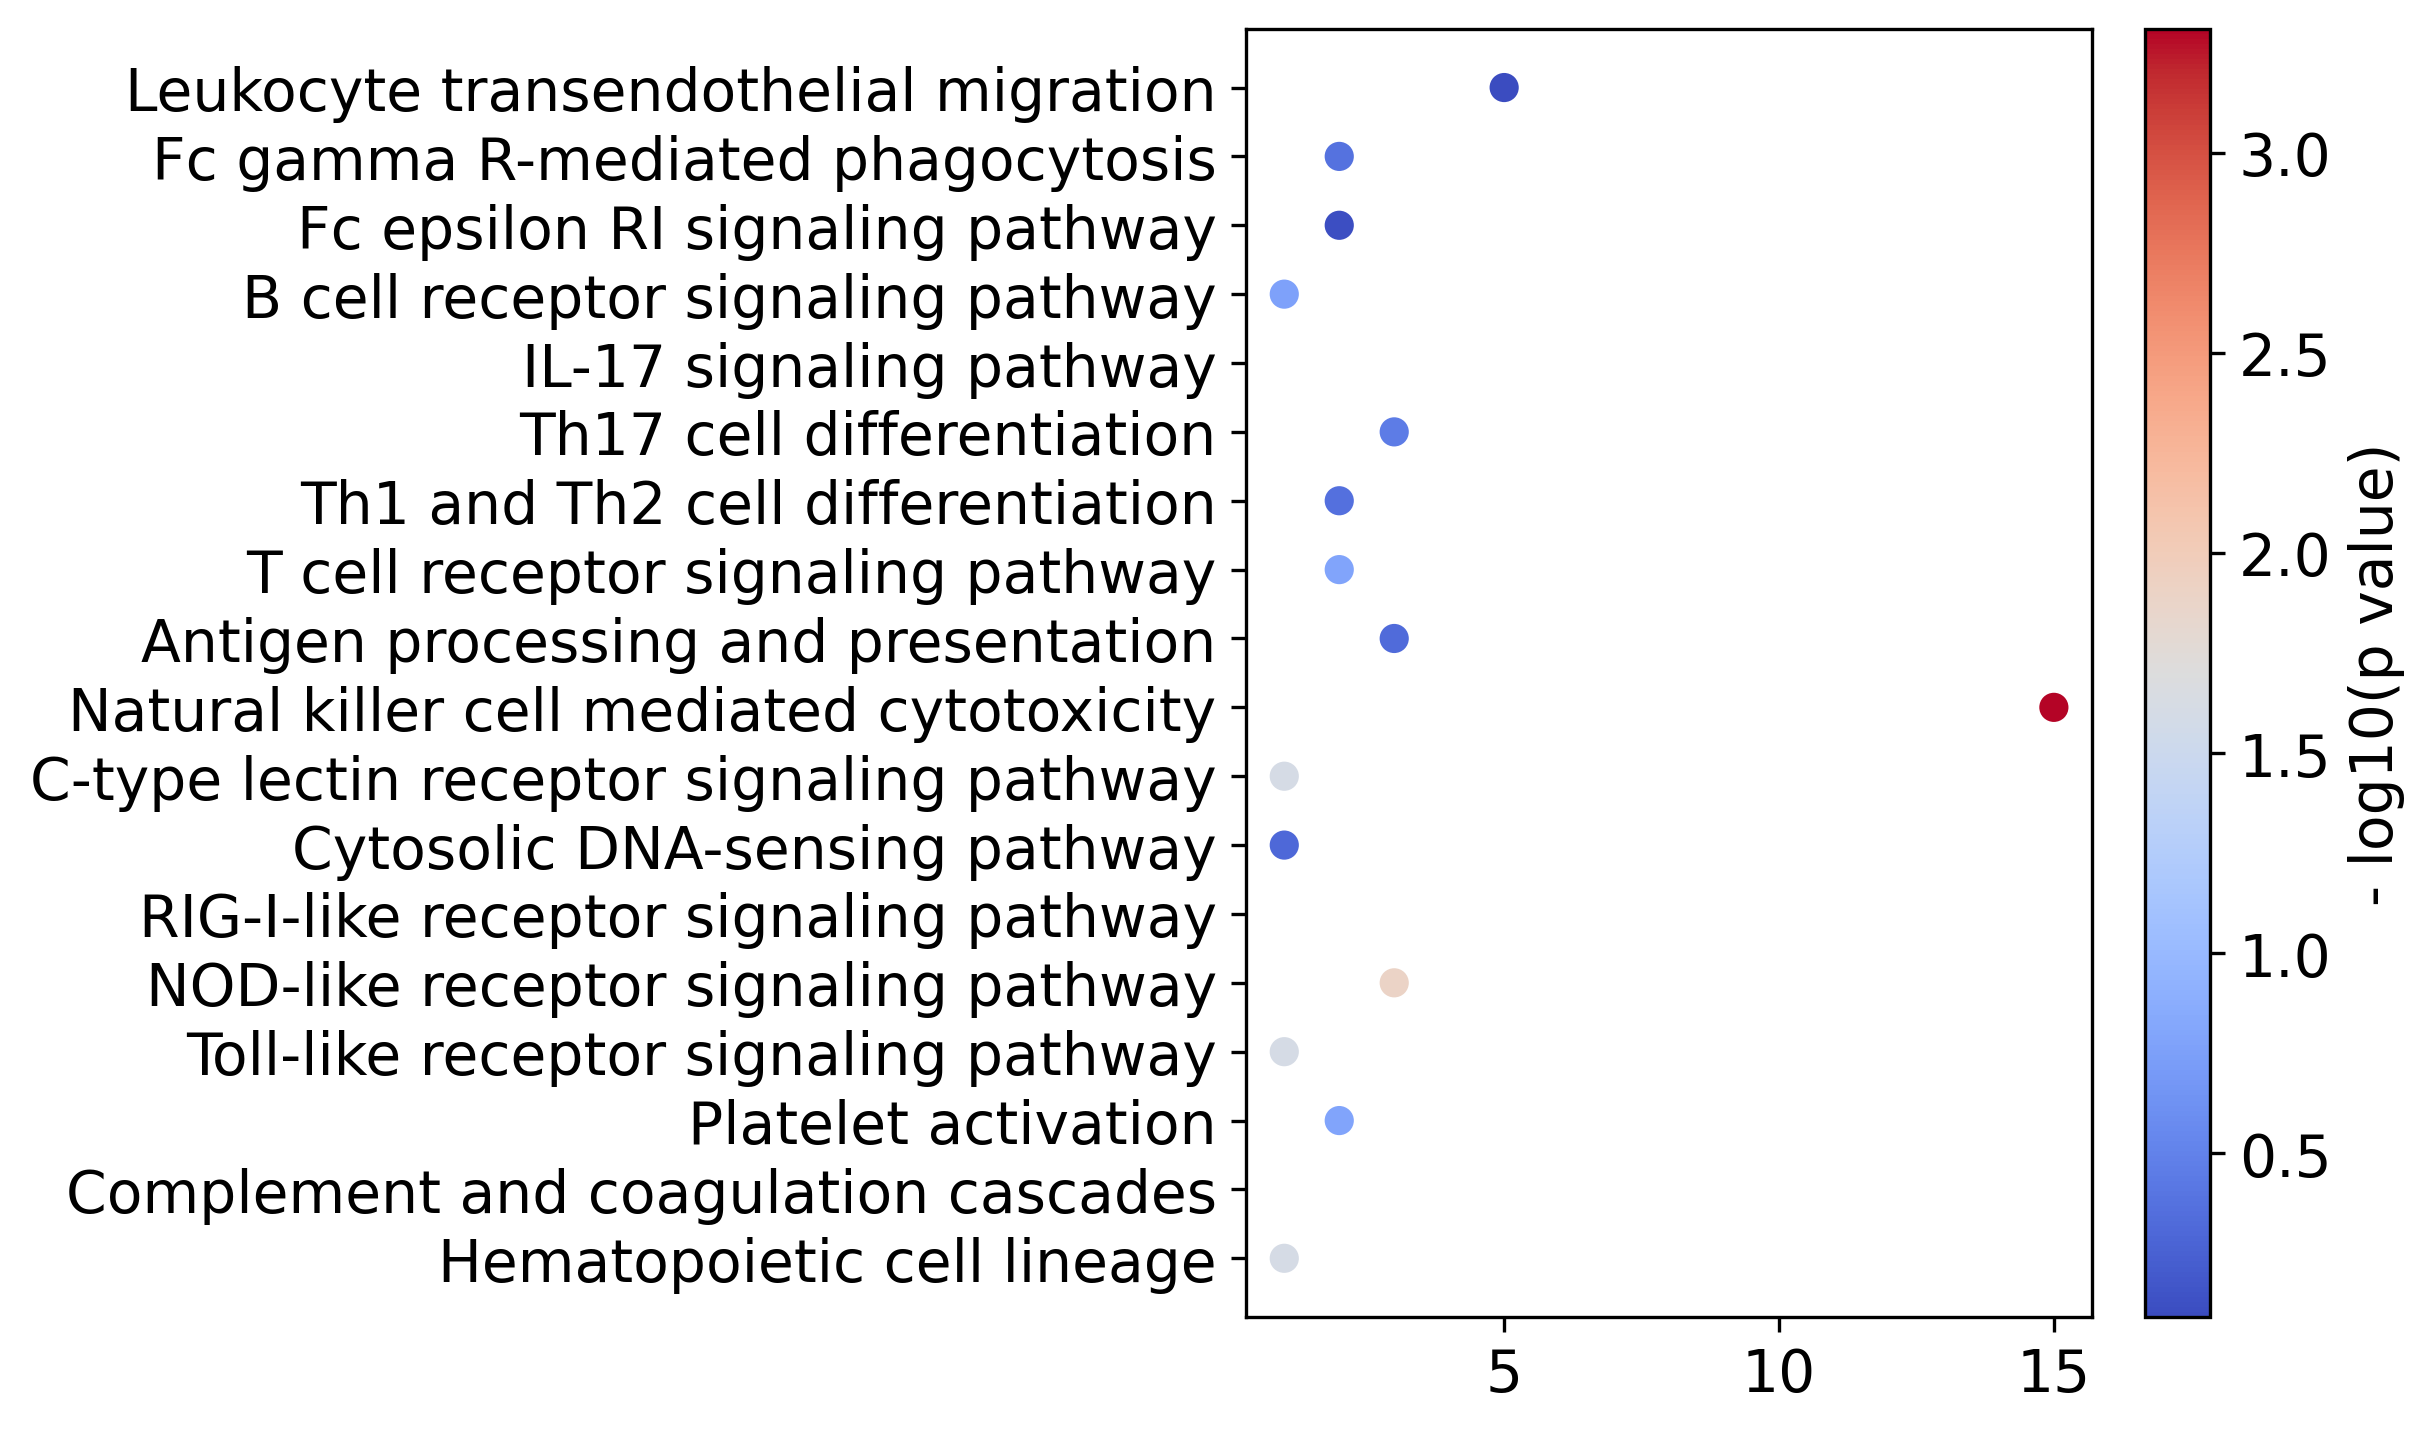

In [26]:
import matplotlib.pyplot as plt
import math

plt.figure(figsize=(8, 5), dpi=300)
scatter = plt.scatter(x=result["study_count"],
                      y=result["pathway_name"],
                      c=[-math.log10(x) for x in result["pvalue"]],
                      cmap="coolwarm")

cbar = plt.colorbar()
cbar.set_label("- log10(p value)")

plt.grid(b=None)
plt.tight_layout()
plt.savefig(os.path.join(figure_dir, "figure4.png"), bbox_inches='tight')
plt.show()

### Plot pathway

* "Natural killer cell mediated cytotoxicity" (hsa:04650) show a significant p value

In [27]:
pathway = KEGGPathwayResolver(org="hsa").get_pathway("04650")

DEBUG:root:Load pathway path:hsa04650 from file


In [28]:
renderer = KEGGPathwayRenderer(kegg_pathway=pathway)

In [29]:
diffexp_df[["entrez"]] = diffexp_df[["entrez"]].astype(int)
diffexp_df.head()

cluster names         pvals     pvals_adj  logfoldchanges  entrez
0        4  NKG7  4.321025e-96  5.925854e-92        6.887014    4818
1        4  GNLY  4.640732e-88  2.380879e-84        7.831739   10578
2        4  GZMB  5.208282e-88  2.380879e-84        7.669129    3002
3        4  CTSW  1.202514e-86  4.122818e-83        4.828786    1521
4        4  PRF1  5.056639e-85  1.386935e-81        6.324315    5551

In [30]:
overlay = dict(zip(list(diffexp_df["entrez"]), list(diffexp_df["logfoldchanges"])))
renderer.set_overlay(overlay)
dot_string = renderer.raw_render()

In [31]:
with open(os.path.join(figure_dir, "figure5.dot"), "w") as f:
    f.write(dot_string)

In [32]:
import pydot

graphs = pydot.graph_from_dot_data(dot_string)
graph = graphs[0]
graph.write_png(os.path.join("/tmp", "figure5.png"))

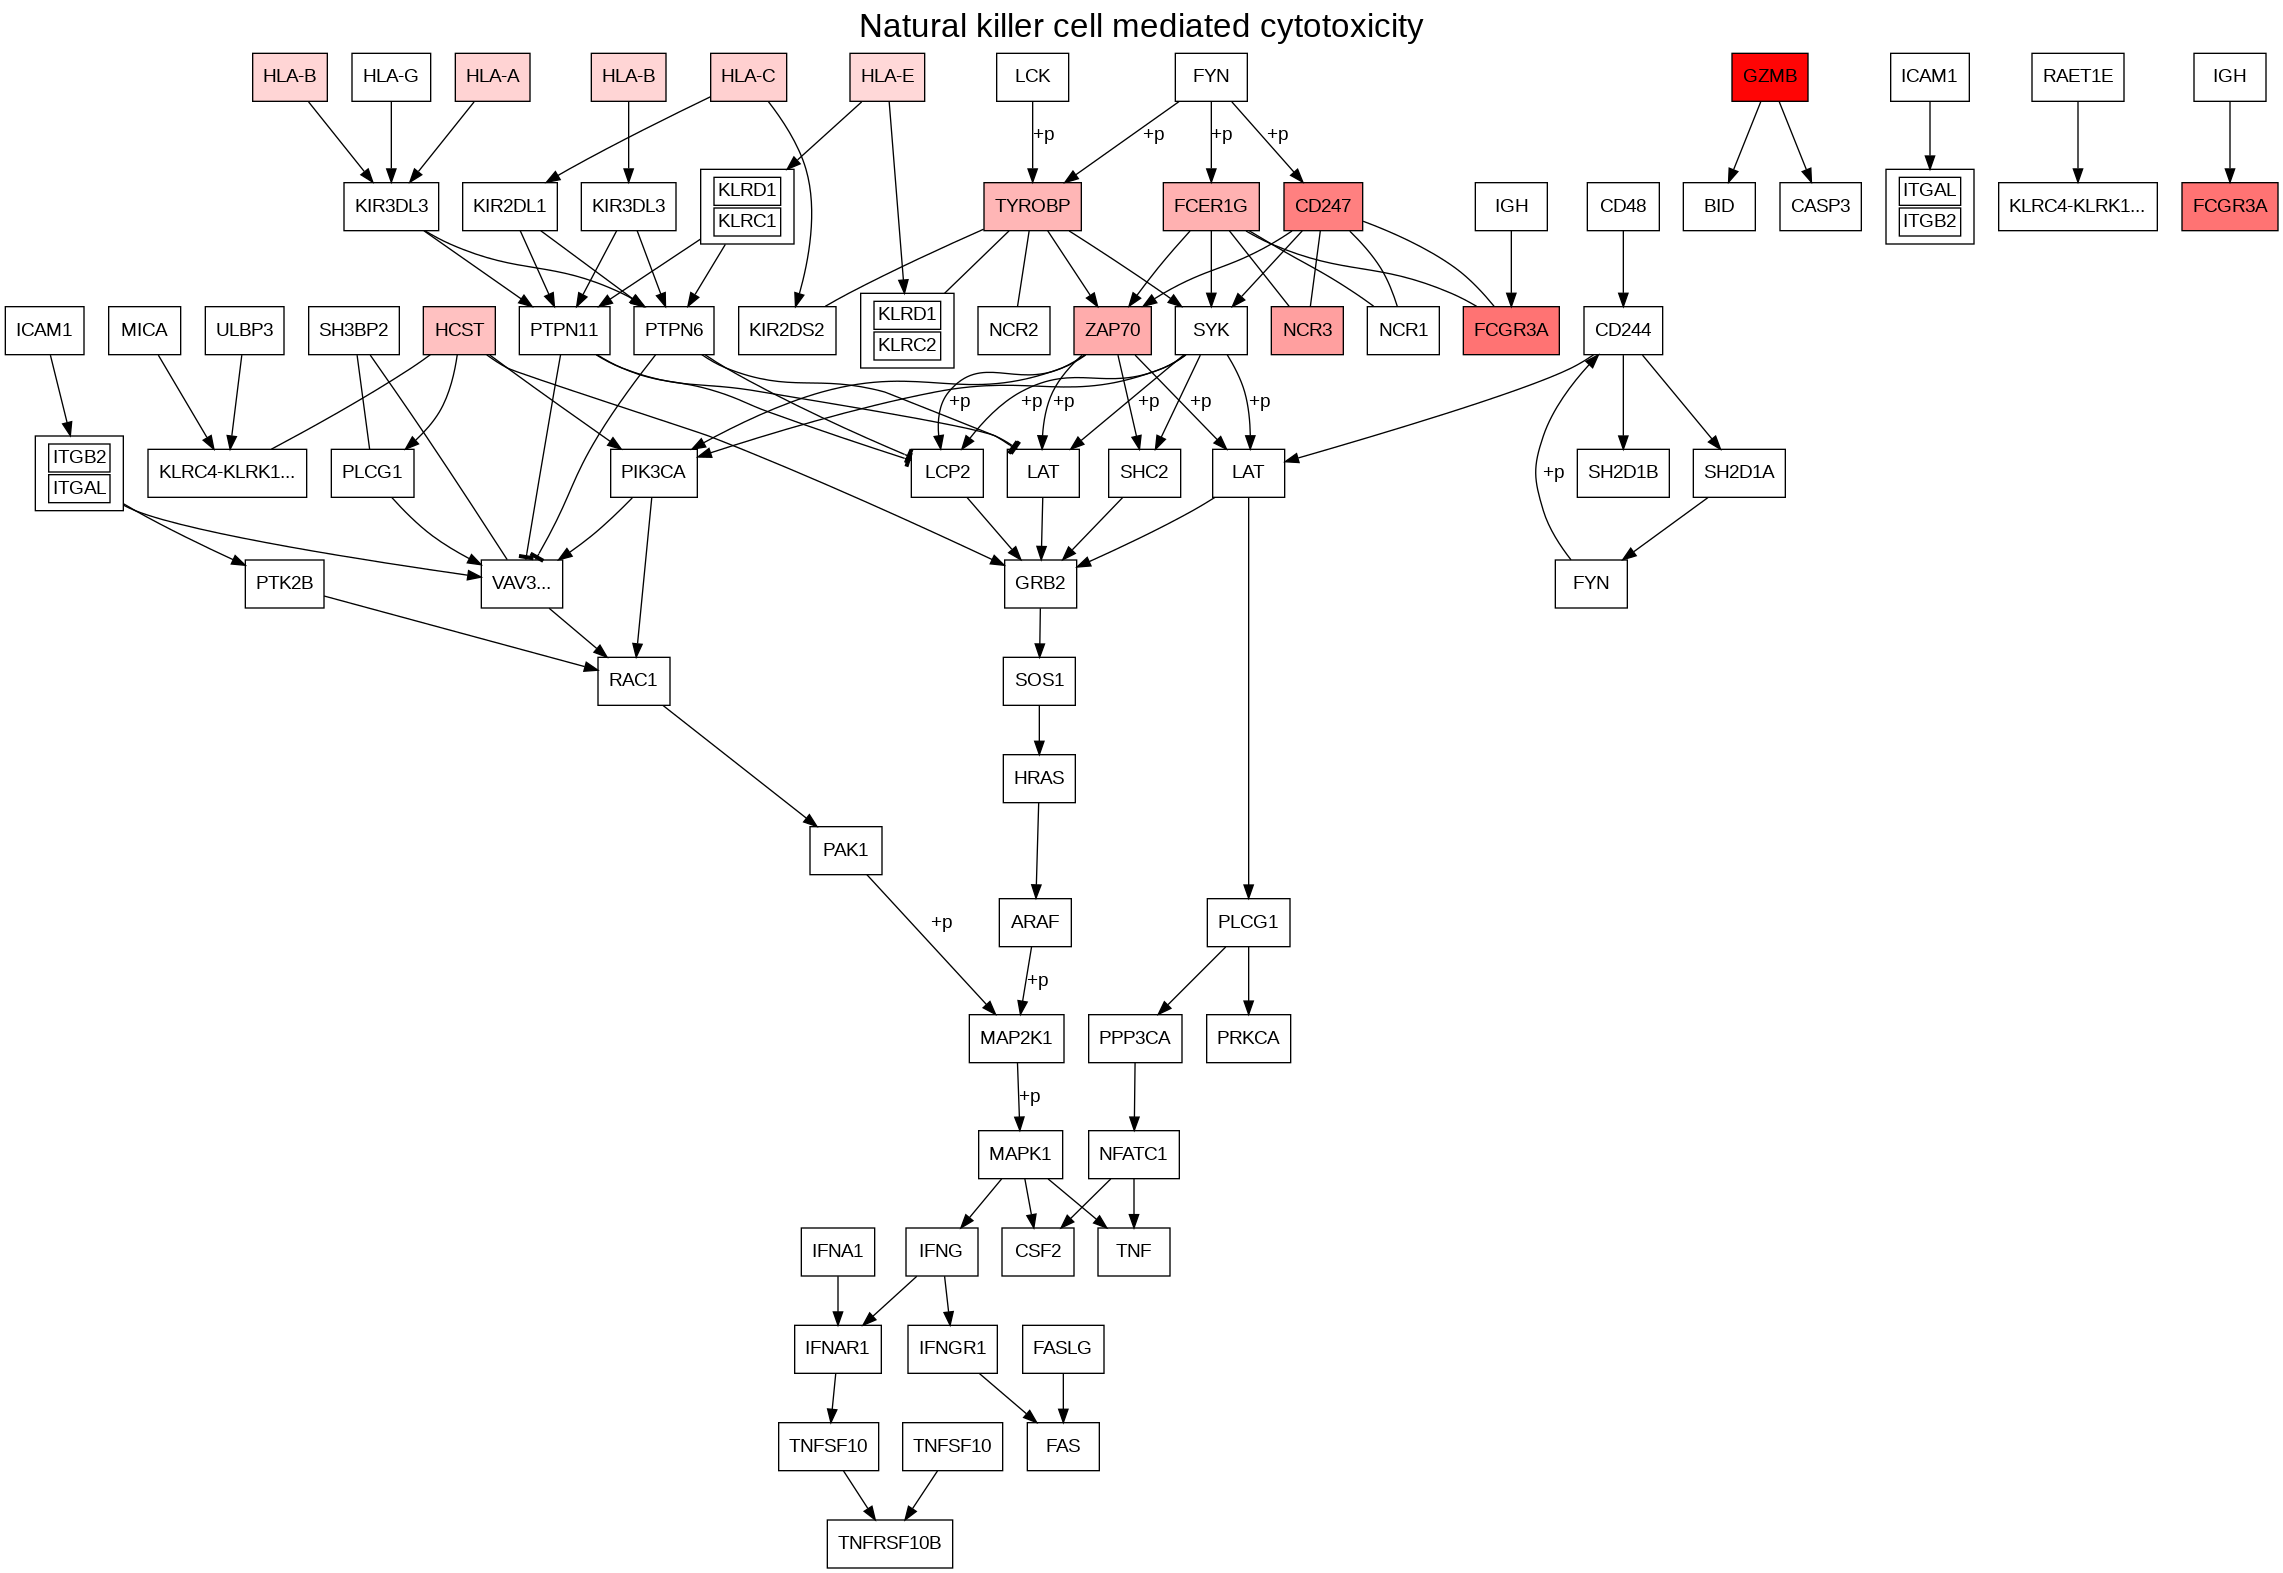

In [33]:
from IPython.display import Image, display
img = Image(os.path.join("/tmp", "figure5.png"))
display(img)

DEBUG:PIL.PngImagePlugin:STREAM b'IHDR' 16 13
DEBUG:PIL.PngImagePlugin:STREAM b'bKGD' 41 6
DEBUG:PIL.PngImagePlugin:b'bKGD' 41 6 (unknown)
DEBUG:PIL.PngImagePlugin:STREAM b'IDAT' 59 8192
DEBUG:matplotlib.colorbar:locator: <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f31d2370c70>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.colorbar._ColorbarAutoLocator object at 0x7f31d2370c70> on colorbar
DEBUG:matplotlib.colorbar:Setting pcolormesh
DEBUG:matplotlib.colorbar:locator: <matplotlib.ticker.FixedLocator object at 0x7f31d237ccd0>
DEBUG:matplotlib.colorbar:Using auto colorbar locator <matplotlib.ticker.FixedLocator object at 0x7f31d237ccd0> on colorbar
DEBUG:matplotlib.font_manager:findfont: Matching sans\-serif:style=normal:variant=normal:weight=normal:stretch=normal:size=10.0.
DEBUG:matplotlib.font_manager:findfont: score(<Font 'STIXGeneral' (STIXGeneralBolIta.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'DejaVu

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Roman Dunhill' (lmromandunh10-oblique.otf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Mono' (lmmono10-regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'P052' (P052-Roman.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Italic.ttf) italic normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nimbus Mono PS' (NimbusMonoPS-Bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-Regular.ttf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Sans' (lmsans8-oblique.otf) oblique normal 400 normal>) = 11.05
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Roman Caps' (lmrom

DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Sans' (LiberationSans-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Roman' (lmroman8-bold.otf) normal normal 700 normal>) = 10.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Nimbus Sans Narrow' (NimbusSansNarrow-Oblique.otf) oblique normal 400 condensed>) = 11.25
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Mono Light' (lmmonolt10-boldoblique.otf) oblique normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Liberation Serif' (LiberationSerif-BoldItalic.ttf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'C059' (C059-BdIta.otf) italic normal 700 normal>) = 11.335
DEBUG:matplotlib.font_manager:findfont: score(<Font 'Latin Modern Roman Slanted' (lmromanslant8-regular.otf) normal normal 400 normal>) = 10.05
DEBUG:matplotlib.font_manager:findfont: score(<Fon

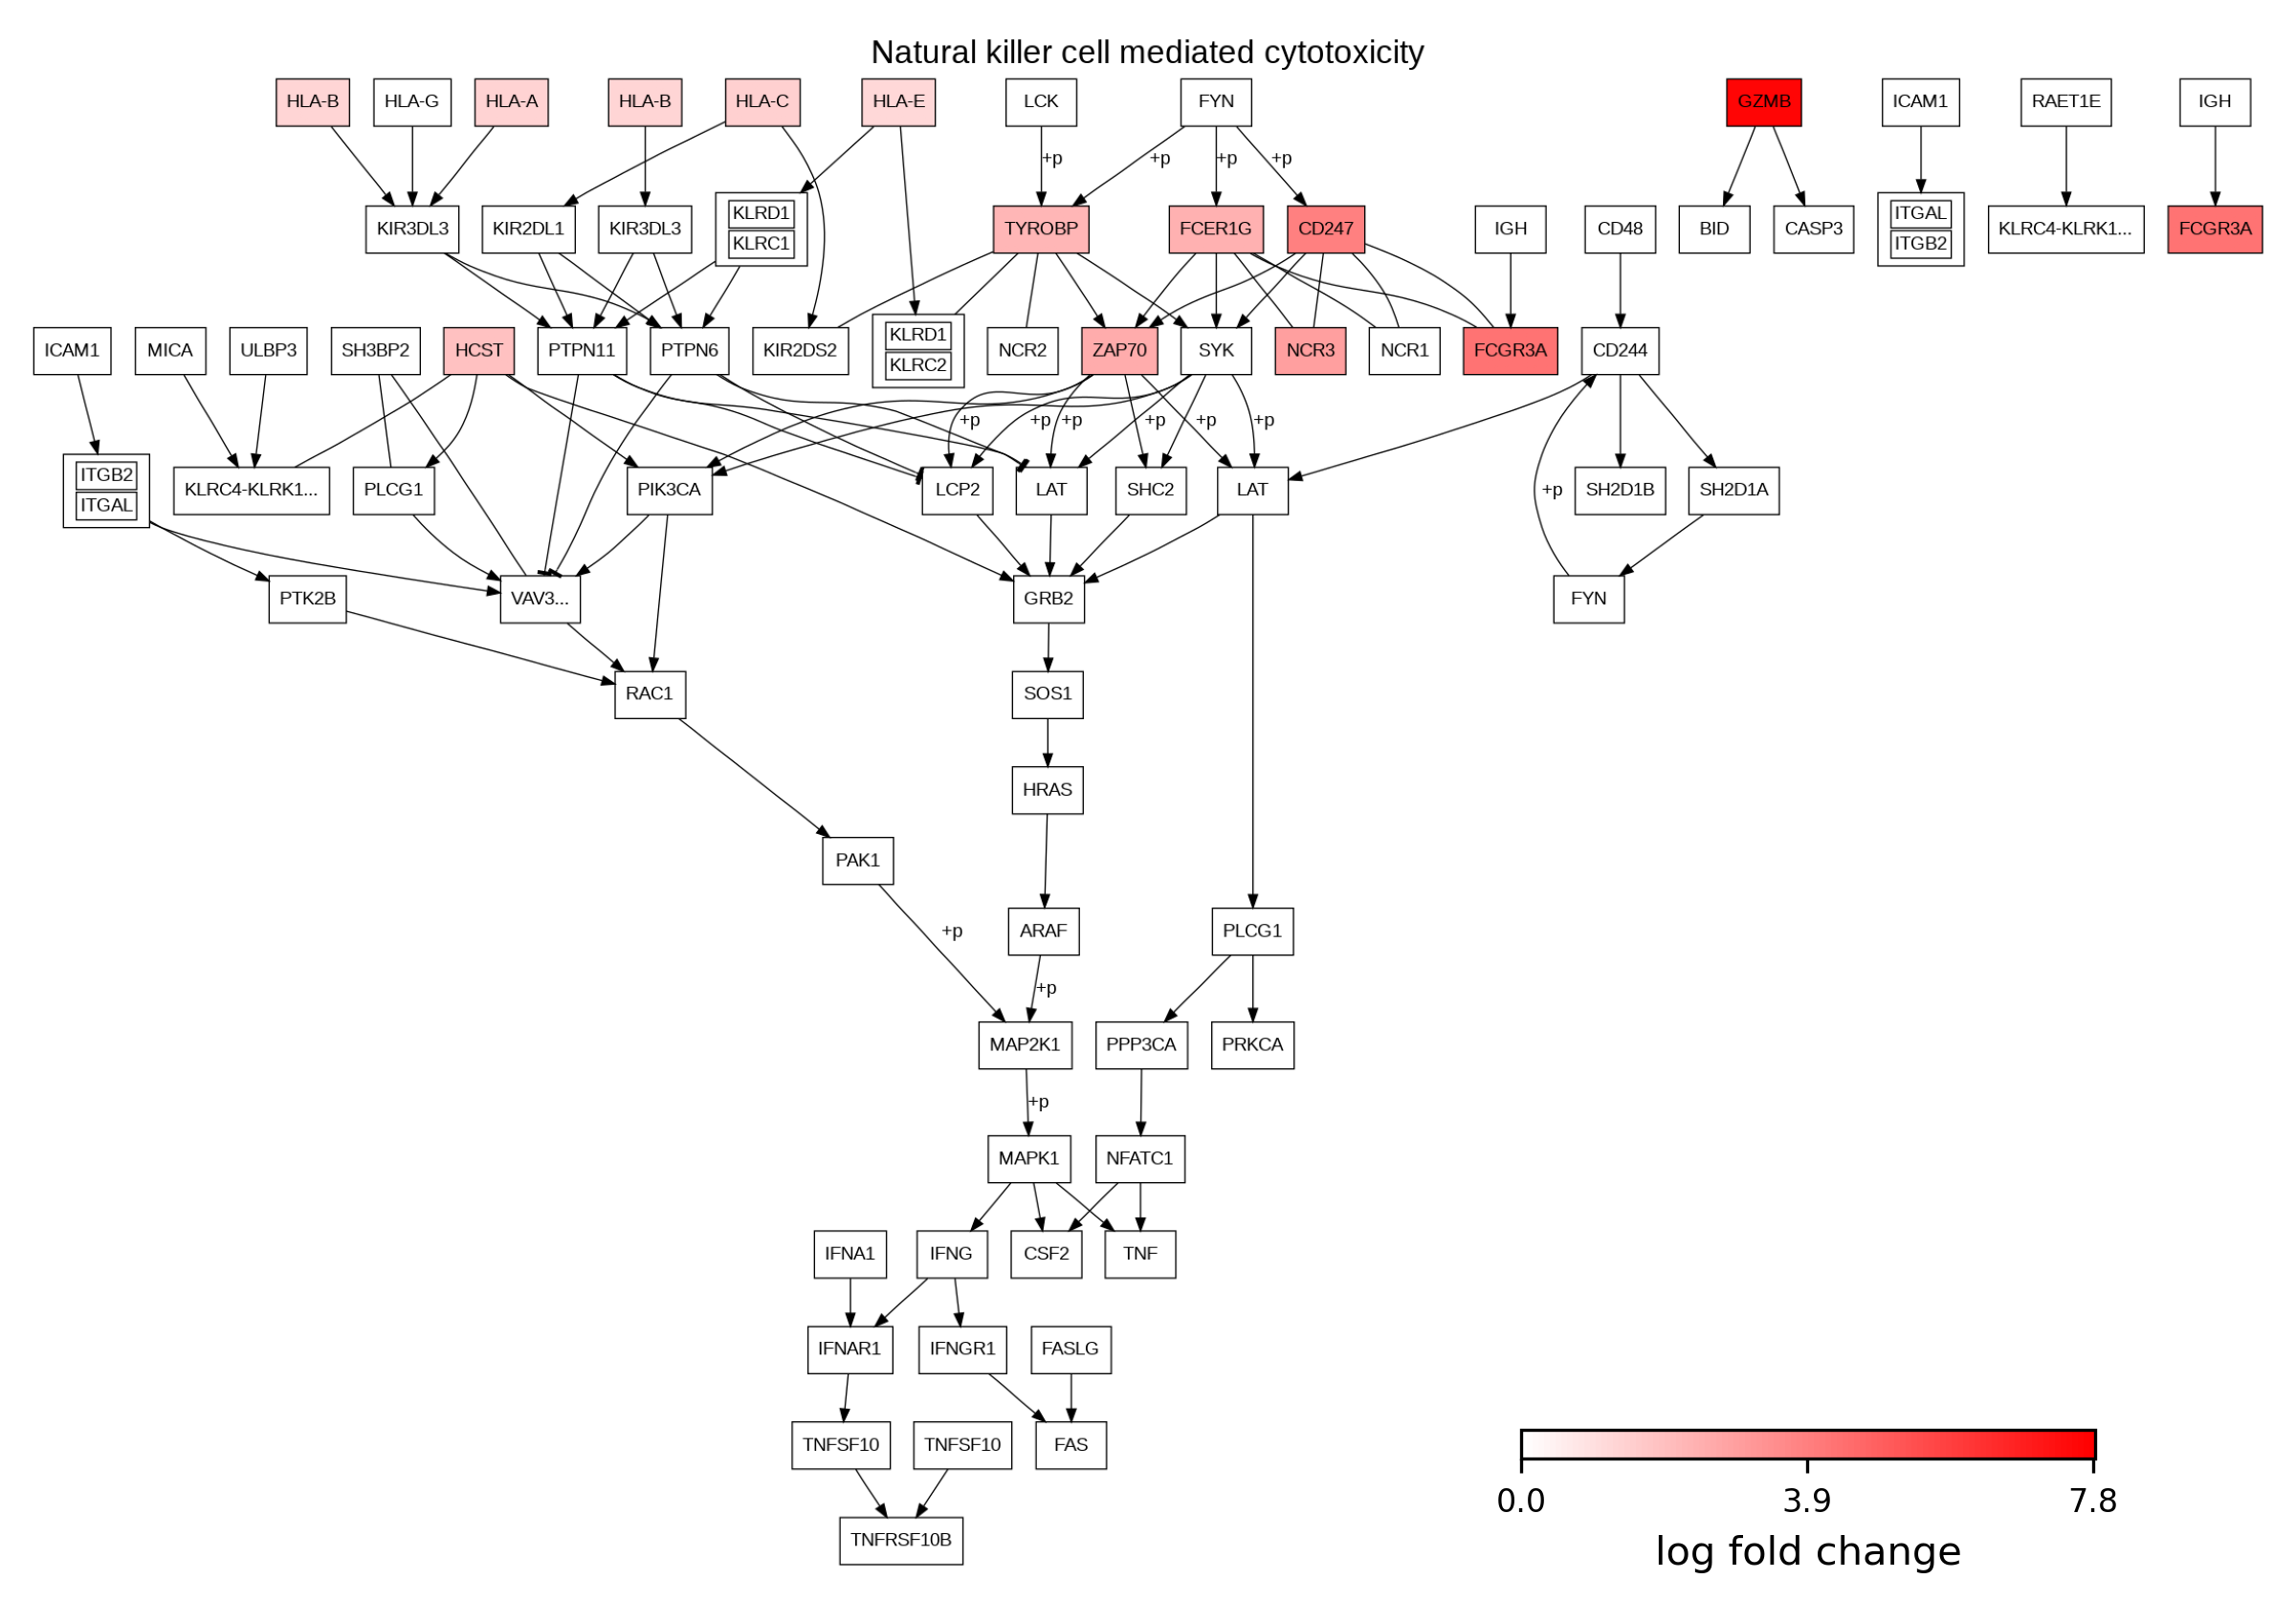

In [34]:
import matplotlib.image as mpimg
from matplotlib.colors import ListedColormap, LinearSegmentedColormap, TwoSlopeNorm
import matplotlib as mpl


cmap_downreg = renderer.cmap_downreg
cmap_downreg = reversed(cmap_downreg)
cmap_upreg = renderer.cmap_upreg

lmin = 0
lcenter = 0
lmax = 0

if renderer.exp_min > 0:
    cmap = ListedColormap(cmap_upreg)    
    norm = mpl.colors.Normalize(vmin=0, vmax=renderer.exp_max)
    lmin = 0
    lmax = renderer.exp_max
    lcenter = renderer.exp_max / 2

elif renderer.exp_max < 0:
    cmap = ListedColormap(cmap_downreg)
    norm = mpl.colors.Normalize(vmin=renderer.exp_min, vmax=0)
    lmin = renderer.exp_min
    lmax = 0
    lcenter = renderer.exp_max / 2
else:
    cmap = ListedColormap([*cmap_downreg, *cmap_upreg])
    norm = TwoSlopeNorm(vmin=renderer.exp_min, vcenter=0, vmax=renderer.exp_max)
    lmin = renderer.exp_min
    lmax = renderer.exp_max
    lcenter = renderer.exp_max / 2

fig, ax = plt.subplots(figsize=(10,10))
ax.set_axis_off()
plt.grid(b=None)
cax = fig.add_axes([0.7, 0.3, 0.2, 0.01])

img = mpimg.imread(os.path.join("/tmp", "figure5.png"))
im = ax.imshow(img)

cb1 = mpl.colorbar.ColorbarBase(cax, cmap=cmap,
                                norm=norm,
                                orientation='horizontal')


cb1.set_ticks([round(lmin, 1), round(lcenter, 1), round(lmax, 1)])
cb1.set_label('log fold change')

for xtick in (cax.get_xticklabels()):
    xtick.set_fontsize(8)
    
cax.xaxis.label.set_fontsize(10)

plt.savefig(os.path.join(figure_dir, "figure5.png"), bbox_inches='tight')
plt.show()